In [7]:
!pip uninstall -y gym

Found existing installation: gym 0.26.2
Uninstalling gym-0.26.2:
  Successfully uninstalled gym-0.26.2


In [1]:

!pip install gym
!pip install gym[atari]
!pip install gym[accept-rom-license]

Defaulting to user installation because normal site-packages is not writeable
  Using cached gym-0.26.2-py3-none-any.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Implementation of a Decision Transformer for the Atari game Breakout
import gym
import torch
import torch.nn as nn
from preprocess import CustomWrapper
from ReplayBuffer import ReplayBuffer

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [3]:
# Initialize the environment
env = gym.make('BreakoutNoFrameskip-v4', render_mode='rgb_array')
# Preprocess the environment (important if you want luminance to put grayscale as False)
env = CustomWrapper(env, noop_max=30, frame_skip=4, screen_size=84, luminance_obs=True, grayscale_obs=False)
# Stack 4 frames
env = gym.wrappers.FrameStack(env, 4)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Image shape:  (4, 84, 84)
Image type:  uint8


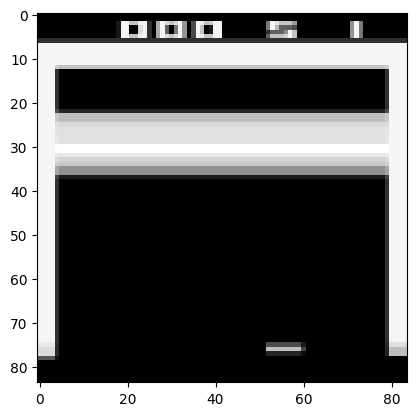

In [4]:
env.reset()
img, _, _, _, _ = env.step(0)
print('Image shape: ', img.shape)
print('Image type: ', img.dtype)

import matplotlib.pyplot as plt
plt.imshow(img[0], cmap='gray')

In [5]:
def get_action_space():
    return env.action_space.n

def get_obs_space():
    return env.observation_space.shape

class DT(nn.Module):
    def __init__(self, obs_shape, action_shape, num_layers, d_model, num_heads, dff, max_seq_len, dropout=0.0):
        super().__init__()
        self.obs_shape = obs_shape
        self.action_shape = action_shape
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.max_seq_len = max_seq_len
        self.dropout = dropout

        self.obs_embedding = nn.Linear(obs_shape[0], d_model)
        self.action_embedding = nn.Embedding(action_shape, d_model)
        self.pos_embedding = nn.Embedding(max_seq_len, d_model)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, dff, dropout) for _ in range(num_layers)]
        )

        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, action_shape)
        )

    def forward(self, obs, actions, pad_mask=None, return_logits=True):
        batch_size = obs.shape[0]
        seq_len = obs.shape[1]

        obs = self.obs_embedding(obs)
        actions = self.action_embedding(actions)
        pos = torch.arange(seq_len, device=device).unsqueeze(0).repeat(batch_size, 1)
        pos = self.pos_embedding(pos)

        x = obs + actions + pos

        for layer in self.encoder_layers:
            x = layer(x, pad_mask)

        if return_logits:
            x = self.mlp(x)

        return x
    
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout=0.0):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.dropout = dropout

        self.mha = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, pad_mask=None):
        # x: [batch_size, seq_len, d_model]
        # pad_mask: [batch_size, seq_len]

        # Multihead Attention
        attn_out, _ = self.mha(x, x, x, key_padding_mask=pad_mask)
        attn_out = self.dropout1(attn_out)
        out1 = self.ln1(x + attn_out)

        # MLP
        mlp_out = self.mlp(out1)
        mlp_out = self.dropout2(mlp_out)
        out2 = self.ln2(out1 + mlp_out)

        return out2
    
class DTAgent(nn.Module):
    def __init__(self, obs_shape, action_shape, num_layers, d_model, num_heads, dff, max_seq_len, dropout=0.0):
        super().__init__()
        self.dt = DT(obs_shape, action_shape, num_layers, d_model, num_heads, dff, max_seq_len, dropout=dropout)
        self.obs_shape = obs_shape
        self.action_shape = action_shape
        self.num_layers = num_layers
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.max_seq_len = max_seq_len
        self.dropout = dropout

    def forward(self, obs, agent_state, pad_mask=None, return_logits=True):
        # obs: [batch_size, seq_len, obs_shape]
        # agent_state: [batch_size, d_model]
        batch_size = obs.shape[0]
        seq_len = obs.shape[1]

        # Get actions
        actions = torch.randint(self.action_shape, (batch_size, seq_len), device=device)
        # Get DT logits
        logits = self.dt(obs, actions, pad_mask, return_logits)
        # Get action probabilities
        probs = nn.functional.softmax(logits, dim=-1)
        # Sample actions
        actions = torch.multinomial(probs, 1).squeeze(-1)
        # Get log probs
        log_probs = nn.functional.log_softmax(logits, dim=-1)
        log_probs = torch.gather(log_probs, dim=-1, index=actions.unsqueeze(-1)).squeeze(-1)
        # Get entropy
        entropy = -(log_probs * probs).sum(-1)

        agent_state = torch.zeros(batch_size, self.d_model, device=device)

        model_outputs = {
            'action': actions,
            'log_probs': log_probs,
            'entropy': entropy,
            'agent_state': agent_state
        }

        return model_outputs
    
    def initial_state(self, batch_size, device):
        return torch.zeros(batch_size, self.d_model, device=device)
    
    def get_action(self, obs, agent_state, pad_mask=None, return_logits=False):
        with torch.no_grad():
            model_outputs = self.forward(obs, agent_state, pad_mask, return_logits)
        return model_outputs
    
    def evaluate_actions(self, obs, agent_state, actions, pad_mask=None):
        model_outputs = self.forward(obs, agent_state, pad_mask, return_logits=True)
        log_probs = model_outputs['log_probs']
        entropy = model_outputs['entropy']
        return log_probs, entropy
    
    def get_value(self, obs, agent_state, pad_mask=None):
        with torch.no_grad():
            model_outputs = self.forward(obs, agent_state, pad_mask, return_logits=True)
        logits = model_outputs['logits']
        return logits
    
    def get_probs(self, obs, agent_state, pad_mask=None):
        with torch.no_grad():
            model_outputs = self.forward(obs, agent_state, pad_mask, return_logits=True)
        probs = nn.functional.softmax(model_outputs['logits'], dim=-1)
        return probs
    
    def get_log_probs(self, obs, agent_state, pad_mask=None):
        with torch.no_grad():
            model_outputs = self.forward(obs, agent_state, pad_mask, return_logits=True)
        log_probs = nn.functional.log_softmax(model_outputs['logits'], dim=-1)
        return log_probs
    
    def get_entropy(self, obs, agent_state, pad_mask=None):

        with torch.no_grad():
            model_outputs = self.forward(obs, agent_state, pad_mask, return_logits=True)
        probs = nn.functional.softmax(model_outputs['logits'], dim=-1)
        entropy = -(probs * model_outputs['log_probs']).sum(-1)
        return entropy
    
    def get_action_and_value(self, obs, agent_state, pad_mask=None):
        with torch.no_grad():
            model_outputs = self.forward(obs, agent_state, pad_mask, return_logits=True)
        probs = nn.functional.softmax(model_outputs['logits'], dim=-1)
        action = torch.multinomial(probs, 1).squeeze(-1)
        return action, model_outputs['logits']
    
    def get_action_and_log_probs(self, obs, agent_state, pad_mask=None):
        with torch.no_grad():
            model_outputs = self.forward(obs, agent_state, pad_mask, return_logits=True)
        probs = nn.functional.softmax(model_outputs['logits'], dim=-1)
        action = torch.multinomial(probs, 1).squeeze(-1)
        log_probs = nn.functional.log_softmax(model_outputs['logits'], dim=-1)
        log_probs = torch.gather(log_probs, dim=-1, index=action.unsqueeze(-1)).squeeze(-1)
        return action, log_probs


# Hyperparameters
obs_shape = get_obs_space()
action_shape = get_action_space()
num_layers = 2
d_model = 512
num_heads = 8
dff = 1024
max_seq_len = 4

# Initialize the agent
agent = DTAgent(obs_shape, action_shape, num_layers, d_model, num_heads, dff, max_seq_len, dropout=0.0).to(device)

# Initialize the optimizer
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize the replay buffer
replay_buffer = ReplayBuffer(100000)



# Initialize the agent state
agent_state = agent.initial_state(batch_size=1, device=device)
# Initialize the target agent state
agent_target_state = agent.initial_state(batch_size=1, device=device)

# Initialize the total reward
total_reward = 0
# Initialize the total steps
total_steps = 0
# Initialize the episode length
episode_length = 0


# Training loop
for i in range(100000):
    obs = env.reset()
    done = False
    while not done:
        # Get action
        action, log_probs = agent.get_action_and_log_probs(obs, agent_state, pad_mask=None)
        # Take step
        next_obs, reward, done, _ = env.step(action)
        # Add to replay buffer
        replay_buffer.add(obs, action, reward, next_obs, done)
        # Update obs
        obs = next_obs

        # Sample from replay buffer
        obs, action, reward, next_obs, done = replay_buffer.sample(32)

        # Compute loss
        logits = agent.get_value(obs, agent_state, pad_mask=None)
        loss = loss_fn(logits, reward)

        # Backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update agent state
        agent_state = agent_target_state
        # Update total reward
        total_reward += reward
        # Update total steps
        total_steps += 1
        # Update episode length
        episode_length += 1

        # Update target agent state
        agent_target_state = agent.initial_state(batch_size=1, device=device)

        # Update target network
        if total_steps % 1000 == 0:
            agent_target_state.load_state_dict(agent_state.state_dict())

        # Print info
        if total_steps % 1000 == 0:
            print(f"Total reward: {total_reward}, Episode length: {episode_length}")
            total_reward = 0
            episode_length = 0

# Save the model
torch.save(agent.state_dict(), 'models/dt_atari.pth')

AttributeError: 'tuple' object has no attribute 'shape'